# Scenario F - Dataset Real (Beers NIR)

In this scenario the the probabilistic model is tested on real-world datasets. The model parameters differ per dataset, and are set by the user. The probabilistic model is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot f_{pseudo-Voigt}(x)\big] + a_0 + a_1 \cdot x + \epsilon
\end{equation}

where:

\begin{equation}
\large f_{pseudo-Voigt}(x) = \eta \cdot \frac{\sigma_m^2}{(x-\mu_m)^2 + \sigma_m^2} + (1 - \eta) \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf
from data import Data

## Local configuration

In [3]:
# output for results and images
out_path      = './output_data_real_beers'
file_basename = out_path + '/scenario_data_real_beers'
        
conf = {}
    
# scenario name
conf['scenario'] = 'dataset real'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors) (normal/lognormal/eta_rv)
conf['prior_model'] = 'normal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'eval'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
# if the output dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf

{'scenario': 'dataset real',
 'init_mode': 'adapt_diag',
 'prior_model': 'normal',
 'peak_info': 'yes',
 'model_mode': 'eval',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Import data and plot

In [6]:
# dataset filelocation
dataset_filename = '../../../data/beers/NIR_beers_new.csv'

# dataset object init
data_obj = Data(dataset_filename, shuffle='yes')
data_obj.data.head(5)

,500,502.85,505.7,508.55,511.4,514.25,517.1,519.95,522.8,525.65,...,2469.34999999996,2472.19999999996,2475.04999999996,2477.89999999996,2480.74999999996,2483.59999999996,2486.44999999996,2489.29999999996,2492.14999999996,label
42,-0.002150,-0.002034,-0.001917,-0.001803,-0.001696,-0.001594,-0.001501,-0.001408,-0.001307,-0.001199,...,0.666909,0.672197,0.677099,0.681616,0.685740,0.689452,0.692889,0.696013,0.698684,1
19,0.087040,0.087159,0.087282,0.087414,0.087540,0.087658,0.087767,0.087871,0.087990,0.088135,...,0.764291,0.769739,0.774774,0.779336,0.783529,0.787322,0.790779,0.793840,0.796537,1
35,-0.004829,-0.004713,-0.004591,-0.004475,-0.004378,-0.004286,-0.004193,-0.004102,-0.004006,-0.003904,...,0.677271,0.682889,0.688113,0.692929,0.697404,0.701505,0.705168,0.708427,0.711324,1
15,0.084176,0.084307,0.084444,0.084584,0.084713,0.084834,0.084971,0.085123,0.085263,0.085386,...,0.776392,0.781773,0.786734,0.791301,0.795486,0.799252,0.802634,0.805683,0.808272,1
10,0.086015,0.086132,0.086255,0.086388,0.086513,0.086627,0.086735,0.086839,0.086954,0.087091,...,0.764408,0.769661,0.774436,0.778786,0.782654,0.786136,0.789281,0.791925,0.794173,2


In [7]:
# select single class for inference
sclass = 2
df_cls = data_obj.data.loc[(data_obj.data['label'] == sclass)]

In [8]:
# drop non-data columns
df = df_cls.drop(columns=['label'])

In [9]:
print("total number of spectra      : {0}".format(len(data_obj.data)))
print("total number of x-values     : {0}".format(len(np.array(df.columns.to_list(), dtype='float32'))))
print("total number of classes      : {0}".format(data_obj.classes))
print("selected class for inference : {0}".format(sclass))
print("number of selected spectra   : {0}".format(len(df)))
print("\nclass distribution:")
print(data_obj.data[data_obj.label_column].value_counts())

total number of spectra      : 44
total number of x-values     : 700
total number of classes      : 2
selected class for inference : 2
number of selected spectra   : 16

class distribution:
1    28
2    16
Name: label, dtype: int64


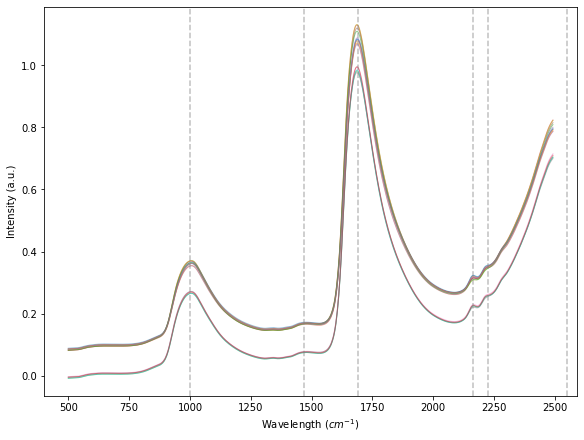

In [10]:
# number of samples to run inference on
nsamples = 15

# set peak information for spectrum
peaks = [1000, 1470, 1690, 2165, 2225, 2550]

# baseline profile
base_shape = 'linear'

# plot dataset (nsamples spectra, classes mixed)
fig.plot_datasets_real(df, peaks, nsamples, savefig='yes', fname=file_basename)

# Initialize models and run inference

In [11]:
ldata  = []
lpeaks = []

# add dataframes and peakinfo to list (for multiple classes or data per class)
ldata.append(df)
lpeaks.append(peaks)

In [12]:
# convert pandas data to numpy arrays
x_val = np.array(df.columns, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values[:nsamples] for i in range(len(ldata))]

In [13]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
    if conf['peak_info'] == 'yes':
        plist = np.array(lpeaks[0], dtype='float32').flatten()
        plist.sort()
        model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=len(peaks),
                              mu_peaks=plist, pmodel=conf['prior_model'], baseline=base_shape)
    else:
        model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=len(peaks),
                                              pmodel=conf['prior_model'], baseline=base_shape)
                
    models.append(model_g)

    with model_g:
        if conf['model_mode'] == 'train':
            print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
            traces.append(trace_g)
            # save inference results
            pm.backends.text.dump(out_path + '/traces_%02d' % (i+1), trace_g)
        else:
            # load traces from disk
            print("loading dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (i+1))
            traces.append(trace_g)

loading dataset #1/1


# Model visualization

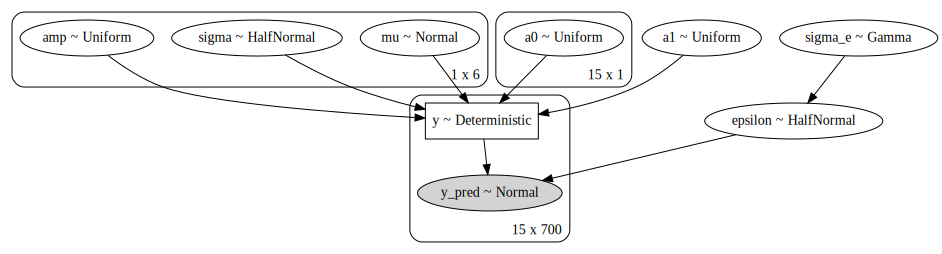

In [14]:
# display first model
pm.model_to_graphviz(models[0])

In [15]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [16]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:59<00:00,  8.41it/s]


In [17]:
# various plots to inspect the inference results
varnames = mdl.get_varnames(traces[0])

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[8], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

#az.summary(traces[1], varnames)

In [18]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(traces, ppc, y_val, varnames)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
df

,r_hat,mcse,ess,bfmi,r2,waic,epsilon
1,1.383429,0.660543,22.971429,1.169884,0.993579,-52996.994605,0.019358


In [19]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

In [20]:
cnf.close(out_path)

# Plot posterior (single dataset)

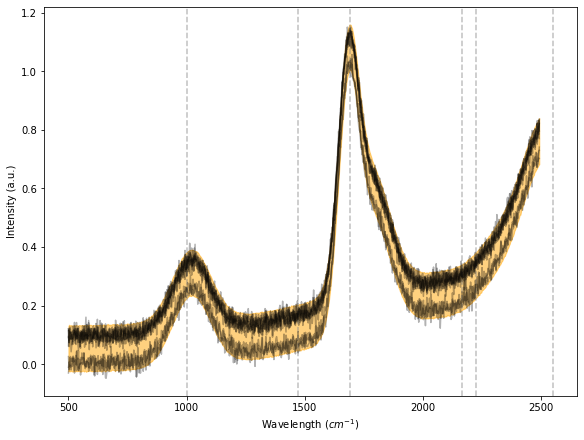

In [32]:
# dataset to plot
n_dataset = 0

# trace number in matrix
n_trace = 0

#fig.plot_posterior_single(x_val, ldata[n_dataset], ppc[n_trace], 5, 
#                              file_basename, hpd_color='yellow', peak_pos=peaks)
fig.plot_posterior_single(x_val, ldata[n_dataset], ppc[n_trace], 10, 
                              file_basename, hpd_color='orange', peak_pos=peaks, no_data='yes')

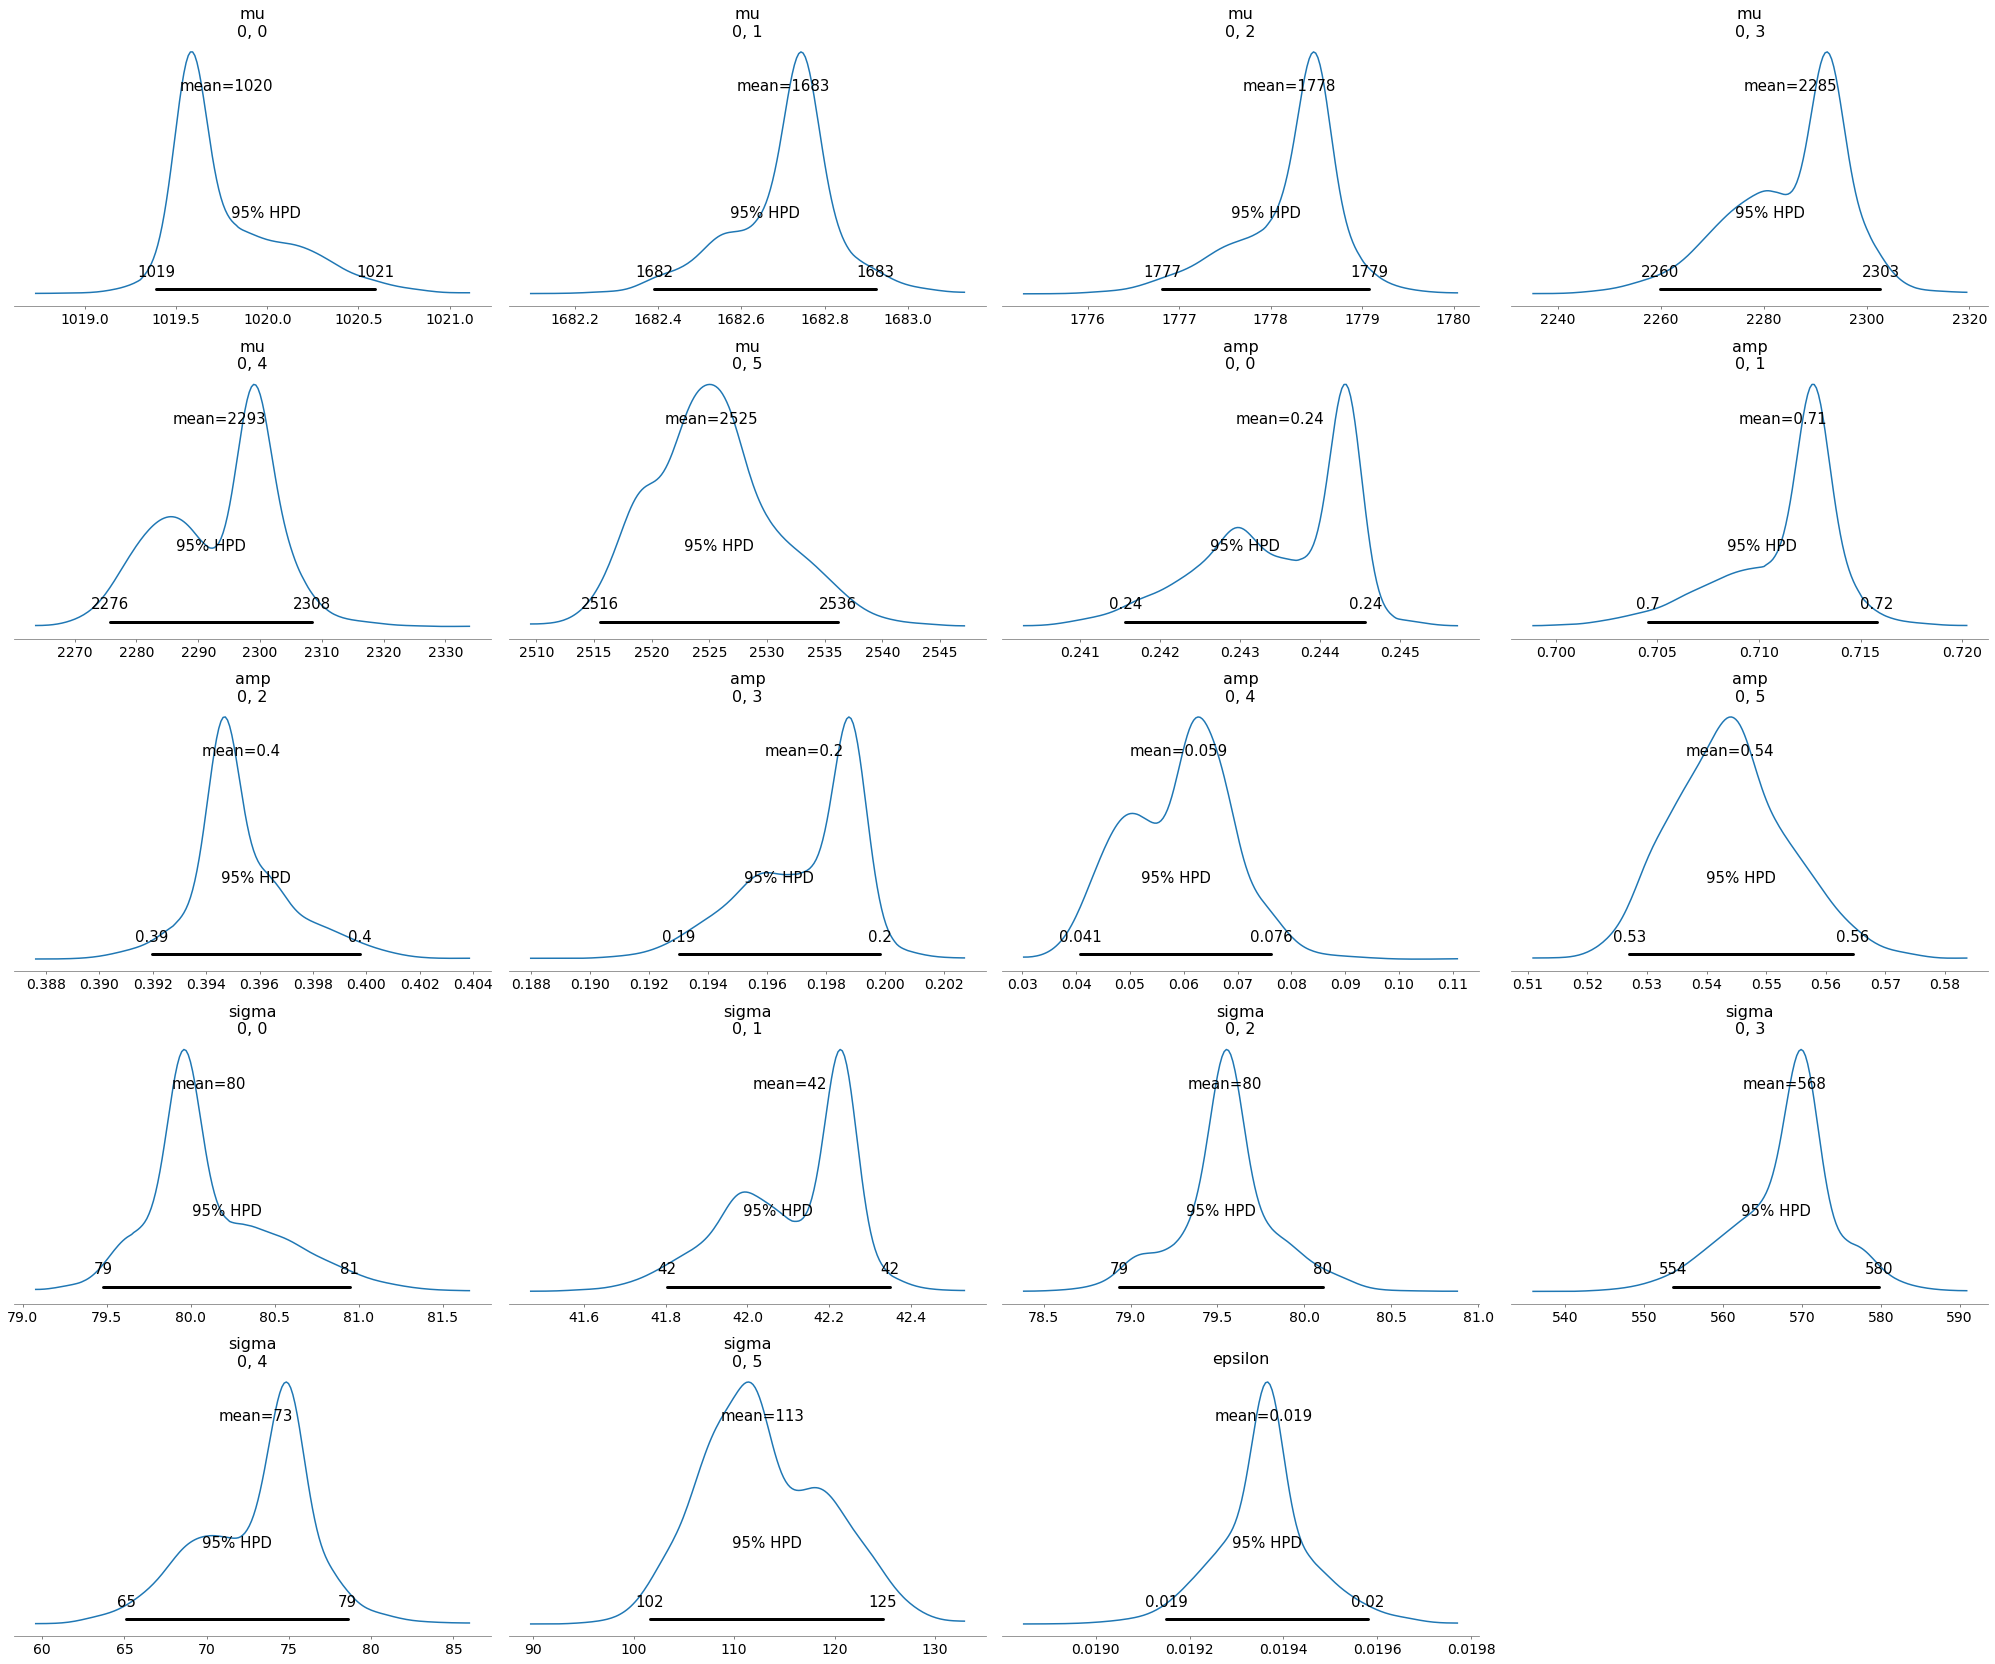

In [22]:
az.plot_posterior(traces[n_trace], ['mu', 'amp', 'sigma', 'epsilon'], credible_interval=0.95);

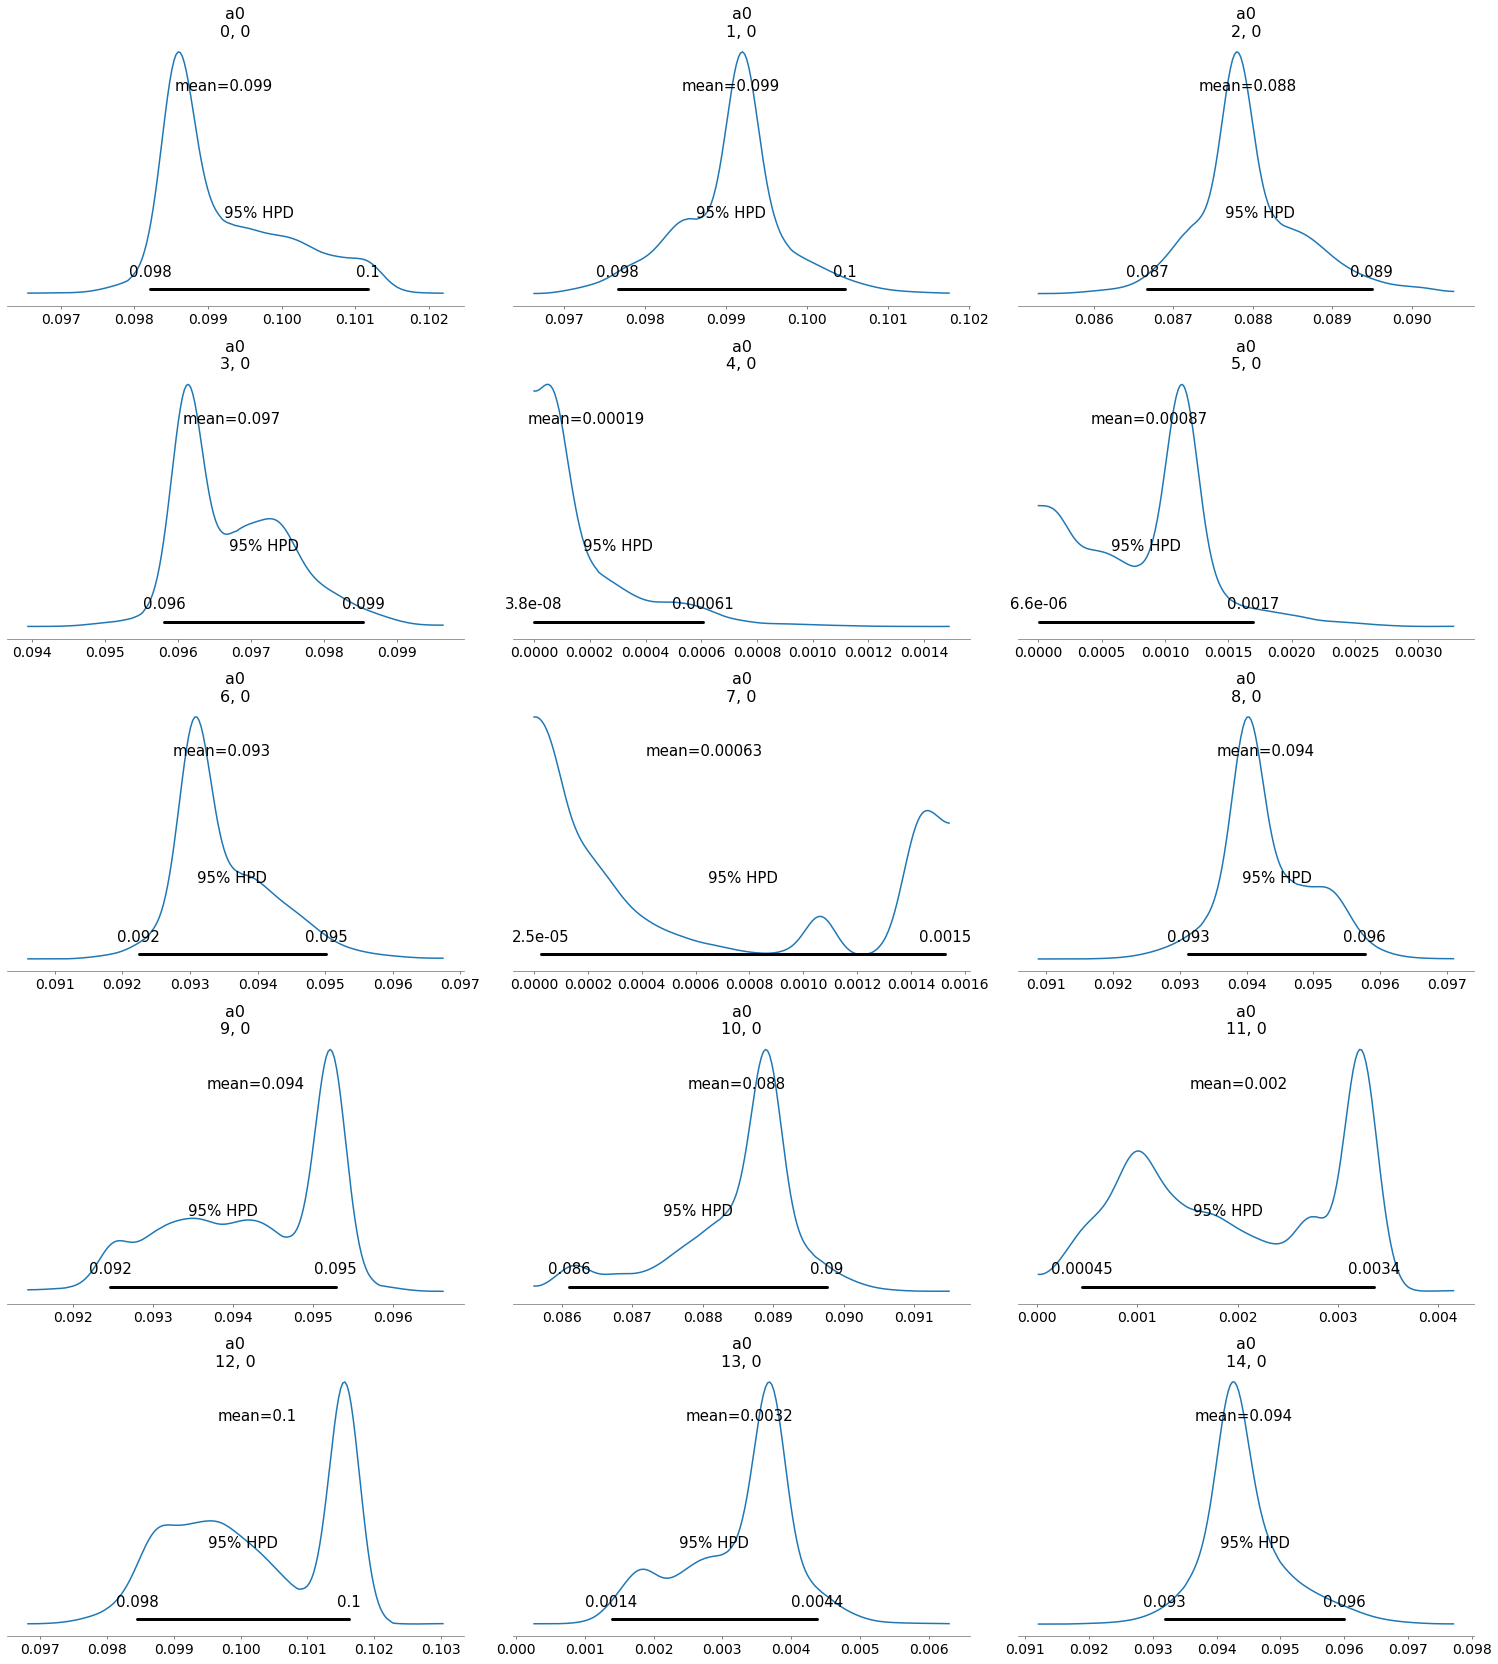

In [23]:
az.plot_posterior(traces[n_trace], ['a0'], credible_interval=0.95);

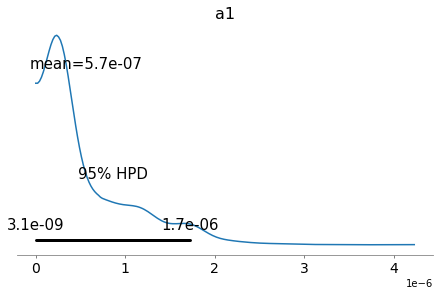

In [24]:
az.plot_posterior(traces[n_trace], ['a1'], credible_interval=0.95);